In [1]:
# Import necessary library
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm
import yaml
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import hashlib

In [2]:
def load_parameter(parameter_direction):
    with open(parameter_direction,'r') as file:
        params = yaml.safe_load(file)
    
    return params

In [3]:
params = load_parameter("config/configuration_file_1.yaml")

In [4]:
params

{'data_direction': 'data/indeks-standar-pencemar-udara-di-spku-bulan-juni-sampai-desember-tahun-2021_1.xlsx',
 'datetime_columns': ['tanggal'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'categori',
 'label_categories': ['BAIK', 'TIDAK SEHAT'],
 'object_columns': ['stasiun', 'critical', 'categori'],
 'predictors': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'range_co': [-1, 100],
 'range_no2': [-1, 100],
 'range_o3': [-1, 160],
 'range_pm10': [-1, 800],
 'range_pm25': [-1, 400],
 'range_so2': [-1, 500],
 'range_stasiun': ['DKI1 (Bunderan HI)',
  'DKI2 (Kelapa Gading)',
  'DKI3 (Jagakarsa)',
  'DKI4 (Lubang Buaya)',
  'DKI5 (Kebon Jeruk) Jakarta Barat']}

# Modeling

In [5]:
X_rus = joblib.load("processed/X_rus.pkl")
y_rus = joblib.load("processed/y_rus.pkl")

X_ros = joblib.load("processed/X_ros.pkl")
y_ros = joblib.load("processed/y_ros.pkl")

X_sm = joblib.load("processed/X_sm.pkl")
y_sm = joblib.load("processed/y_sm.pkl")

X_train = joblib.load("processed/X_train_feng.pkl")
y_train = joblib.load("processed/y_train_feng.pkl")
 
X_valid = joblib.load("processed/X_valid_feng.pkl")
y_valid = joblib.load("processed/y_valid_feng.pkl")

X_test = joblib.load("processed/X_test_feng.pkl")
y_test = joblib.load("processed/y_test_feng.pkl")

Create a baseline performance

In [6]:
# Create a baseline model
y_train.value_counts(normalize = True)

0    0.940493
1    0.059507
Name: categori, dtype: float64

In [7]:
# Sanity check
print(X_rus.shape, X_ros.shape, X_sm.shape, X_valid.shape, X_test.shape)

(82, 11) (1296, 11) (1296, 11) (186, 11) (186, 11)


Create log template

In [8]:
# Create time stamp for current date and time
def time_stamp():
    return datetime.now()

In [9]:
# Create log template
def create_log_template():
    
    """
    This function is to create a log template to store the training log.
    
    :return logger: <dictionary> an empty log template
    """
    
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [10]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()
    
    """
    This function updates the training log file with the current log data.

    :param current_log: <dictionary> dictionary containing the current training log data
    :param log_path: <str> path to the training log file
    :return last_log: <list> updated training log
    """

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

In [11]:
# Create model object
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [12]:
# Create dictionary
list_of_model = {
    "normal" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

In [13]:
def train_eval_model(list_of_model, prefix_model_name, X_train, y_train, data_configuration_name, X_valid, y_valid, log_path):

    """
    This function trains and evaluates a list of machine learning models, logs their performance, 
    and returns the updated training log and list of models.

    :param list_of_model: <list> list of dictionaries containing model name, model object, and other information
    :param prefix_model_name: <str> prefix to be added to the model name
    :param X_train: <pandas DataFrame> training dataset features
    :param y_train: <pandas DataFrame> training dataset labels
    :param data_configuration_name: <str> name of the data configuration used for training
    :param X_valid: <pandas DataFrame> validation dataset features
    :param y_valid: <pandas DataFrame> validation dataset labels
    :param log_path: <str> path to the training log file
    :return training_log: <list> updated training log
    :return list_of_model: <list> list of trained models
    """
    
    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(X_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(X_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

1. Normal

In [14]:
# Checking performance using different model on a normal condition
training_log, list_of_model_nor = train_eval_model(list_of_model["normal"], 
                                                   "baseline_model",
                                                   X_train,
                                                   y_train,
                                                   "normal",
                                                   X_valid,
                                                   y_valid,
                                                   "log/training_log.json")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 3/5 [00:00<00:00, 21.74it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [15]:
# Update list of model
list_of_model["normal"] = copy.deepcopy(list_of_model_nor)

2. Undersampling

In [16]:
# Checking performance using different model after undersampling
training_log, list_of_model_rus = train_eval_model(list_of_model["undersampling"], 
                                                   "baseline_model",
                                                   X_rus,
                                                   y_rus,
                                                   "undersampling",
                                                   X_valid,
                                                   y_valid,
                                                   "log/training_log.json")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 3/5 [00:00<00:00, 24.89it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [17]:
# Update list of model
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

3. Oversampling

In [18]:
# Checking performance using different model after oversampling
training_log, list_of_model_ros = train_eval_model(list_of_model["oversampling"], 
                                                   "baseline_model",
                                                   X_ros,
                                                   y_ros,
                                                   "oversampling",
                                                   X_valid,
                                                   y_valid,
                                                   "log/training_log.json")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 3/5 [00:00<00:00, 18.75it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [19]:
# Update list of model
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

4. SMOTE

In [20]:
# Checking performance using different model after SMOTE
training_log, list_of_model_sm = train_eval_model(list_of_model["smote"], 
                                                  "baseline_model",
                                                  X_sm,
                                                  y_sm,
                                                  "smote",
                                                  X_valid,
                                                  y_valid,
                                                  "log/training_log.json")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 3/5 [00:00<00:00, 16.79it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [21]:
# Update list of model
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

5. Best performance

In [22]:
def training_log_to_df(training_log):
    
    """
    This function takes in the training log and returns a pandas dataframe containing
    all training logs sorted based on f1-score and training time.

    :param training_log: <list> list of training logs
    :return training_res: <pandas dataframe> dataframe containing training logs
    """
    
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [23]:
# Store training log to dataframe
training_res = training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 666.82it/s]


In [24]:
# Show dataframe
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,5444d51566b59bac4af44f80c22c3bd1,0.000999,2023-04-20 13:39:25.666649,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
1,baseline_model-DecisionTreeClassifier,089c87c7d95023fe42e26aeabbbcae14,0.002999,2023-04-20 13:39:25.936180,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
2,baseline_model-XGBClassifier,726b6d4717917240af7533bccc117917,0.032996,2023-04-20 13:39:26.096862,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
3,baseline_model-XGBClassifier,548ba57c8bb1ad6567aa83d5ff583978,0.032997,2023-04-20 13:39:25.806666,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
4,baseline_model-XGBClassifier,c5a9eedbbe57e0bc0c86532a47df6b43,0.054958,2023-04-20 13:39:25.314639,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,normal
5,baseline_model-DecisionTreeClassifier,4f0d910d875c44ee32ea2be95407261c,0.001001,2023-04-20 13:39:25.194086,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
6,baseline_model-LogisticRegression,4300e98f4a2babaf18bef78ee87703b0,0.028508,2023-04-20 13:39:25.162576,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
7,baseline_model-RandomForestClassifier,7bc12571e820dd76c0d67e79ae0c0aee,0.093504,2023-04-20 13:39:25.198086,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
8,baseline_model-RandomForestClassifier,d262665d128c2633680e6b24f9bb7fef,0.112015,2023-04-20 13:39:25.671649,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,oversampling
9,baseline_model-RandomForestClassifier,1803334ee65c80cecf87ba6b3a04a46b,0.128532,2023-04-20 13:39:25.942178,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,smote


In [25]:
def get_best_model(training_log_df, list_of_model):

    """
    This function takes in the training log dataframe and list of model objects and
    returns the best model object based on f1-score and training time.
    
    :param training_log_df: <pandas dataframe> dataframe containing training logs
    :param list_of_model: <dict> dictionary containing list of model objects for each data configuration
    :return model_object: <object> the best performing model object
    :raise RuntimeError: If the best model is not found in the list of model objects
    """
    
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object

In [26]:
# Get the best model object
model = get_best_model(training_res, list_of_model)

In [27]:
# Show best model
model

DecisionTreeClassifier()

Based on the above, the training finds that K-Nearest Neighbour's performance did not contain within the top 10 of training, therefore hyperparameter tuning may need to be performed.

In [28]:
dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

In [29]:
knn_enhance = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420, cv = 5)

In [30]:
list_of_model["normal"].append({"model_name": knn_enhance.__class__.__name__ + "-" + knn_enhance.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enhance), "model_uid": ""})
list_of_model["undersampling"].append({"model_name": knn_enhance.__class__.__name__ + "-" + knn_enhance.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enhance), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enhance.__class__.__name__ + "-" + knn_enhance.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enhance), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enhance.__class__.__name__ + "-" + knn_enhance.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enhance), "model_uid": ""})

1. Normal

In [31]:
training_log, list_of_model_nor_enhanced = train_eval_model([list_of_model["normal"][-1]],
                                                            "hyperparams",
                                                            X_train,
                                                            y_train,
                                                            "normal",
                                                            X_valid,
                                                            y_valid,
                                                            "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 1/1 [00:04<00:00,  4.74s/it]


In [32]:
list_of_model["normal"][-1] = copy.deepcopy(list_of_model_nor_enhanced[0])

2. Undersampling

In [33]:
training_log, list_of_model_rus_enhanced = train_eval_model([list_of_model["undersampling"][-1]],
                                                            "hyperparams",
                                                            X_rus,
                                                            y_rus,
                                                            "undersampling",
                                                            X_valid,
                                                            y_valid,
                                                            "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


In [34]:
list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_enhanced[0])

3. Oversampling

In [35]:
training_log, list_of_model_ros_enhanced = train_eval_model([list_of_model["oversampling"][-1]],
                                                            "hyperparams",
                                                            X_ros,
                                                            y_ros,
                                                            "oversampling",
                                                            X_valid,
                                                            y_valid,
                                                            "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


In [36]:
list_of_model["oversampling"][-1] = copy.deepcopy(list_of_model_ros_enhanced[0])

4. SMOTE

In [37]:
training_log, list_of_model_sm_enhanced = train_eval_model([list_of_model["smote"][-1]],
                                                           "hyperparams",
                                                           X_sm,
                                                           y_sm,
                                                           "smote",
                                                           X_valid,
                                                           y_valid,
                                                           "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


In [38]:
list_of_model["smote"][-1] = copy.deepcopy(list_of_model_sm_enhanced[0])

In [39]:
training_log_to_df(training_log)

100%|██████████| 8/8 [00:00<00:00, 666.71it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,5444d51566b59bac4af44f80c22c3bd1,0.000999,2023-04-20 13:39:25.666649,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
1,baseline_model-DecisionTreeClassifier,089c87c7d95023fe42e26aeabbbcae14,0.002999,2023-04-20 13:39:25.936180,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
2,baseline_model-XGBClassifier,726b6d4717917240af7533bccc117917,0.032996,2023-04-20 13:39:26.096862,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
3,baseline_model-XGBClassifier,548ba57c8bb1ad6567aa83d5ff583978,0.032997,2023-04-20 13:39:25.806666,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
4,baseline_model-XGBClassifier,c5a9eedbbe57e0bc0c86532a47df6b43,0.054958,2023-04-20 13:39:25.314639,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,normal
5,baseline_model-DecisionTreeClassifier,4f0d910d875c44ee32ea2be95407261c,0.001001,2023-04-20 13:39:25.194086,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
6,baseline_model-LogisticRegression,4300e98f4a2babaf18bef78ee87703b0,0.028508,2023-04-20 13:39:25.162576,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
7,baseline_model-RandomForestClassifier,7bc12571e820dd76c0d67e79ae0c0aee,0.093504,2023-04-20 13:39:25.198086,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
8,baseline_model-RandomForestClassifier,d262665d128c2633680e6b24f9bb7fef,0.112015,2023-04-20 13:39:25.671649,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,oversampling
9,baseline_model-RandomForestClassifier,1803334ee65c80cecf87ba6b3a04a46b,0.128532,2023-04-20 13:39:25.942178,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,smote


Turns out after hyperparameter tuning, the K-Nearest Neighbour's performance still did not contain within the top 10. Therefore, we proceed with RandomForestClassifier as the best model.

**Validation set**

In [40]:
# Prediction using input
y_pred_valid = model.predict(X_valid)

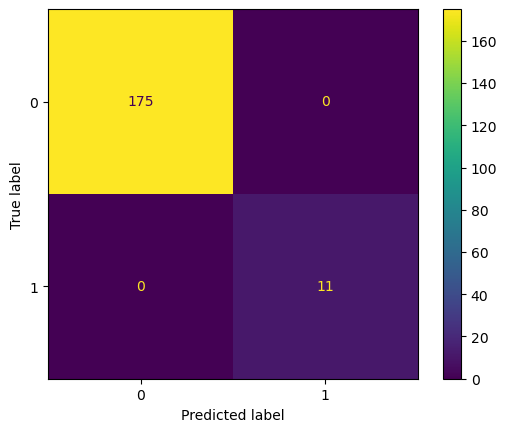

In [41]:
# Show confusion matrix
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid)

In [42]:
# Show classification report
print(classification_report(y_true = y_valid,
                            y_pred = y_pred_valid,
                            target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        11

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186



**Test set**

In [43]:
# Prediction using input
y_pred_test = model.predict(X_test)

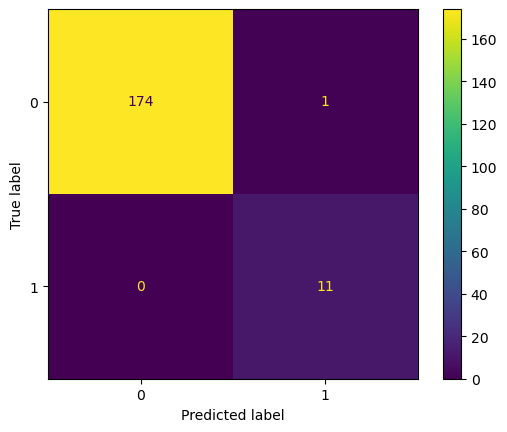

In [44]:
# Show confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

In [45]:
# Show classification report
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       175
           1       0.92      1.00      0.96        11

    accuracy                           0.99       186
   macro avg       0.96      1.00      0.98       186
weighted avg       1.00      0.99      0.99       186



By comparing validation and test set, the performance of test set does not fall significantly from the validation set. Therefore, the leakage may not happen within the dataset.

In [46]:
# Save as pickle
joblib.dump(model, "models/production_model")

['models/production_model']